# Loan Application Status Prediction

### Problem Statement:

This dataset includes details of applicants who have applied for loan. The dataset includes details like credit history, loan amount, their income, dependents etc. 

### Independent Variables:

- Loan_ID
- Gender
- Married
- Dependents
- Education
- Self_Employed
- ApplicantIncome
- CoapplicantIncome
- Loan_Amount
- Loan_Amount_Term
- Credit History
- Property_Area

### Dependent Variable (Target Variable):

- Loan_Status

You have to build a model that can predict whether the loan of the applicant will be approved or not on the basis of the details provided in the dataset. 

In [1]:
# Importing required Libraries
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt

from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

Importing all the necessary libraries here.

In [4]:
df = pd.read_csv(r"loan_prediction.csv")

we have copied the raw data from the github and stored it in our local drive and extracted the dataset using pandas

In [5]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


We can see that the total number of rows are 614 and columns are 13 in our dataframe. In our problem statement we are asked to predict the loan status as our label using the remaining columns as our features making this to be a Classification problem

# Exploratory Data Analysis (EDA)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Using the info method we can see that there are 4 columns with float data type, 1 column with integer data type and 8 columns that have object data type. We will try to spearate these columns into numeric and object datatypes for easier analysis.

In [7]:
df.nunique().to_frame("Unique Values")

,Unique Values
Loan_ID,614
Gender,2
Married,2
Dependents,4
Education,2
Self_Employed,2
ApplicantIncome,505
CoapplicantIncome,287
LoanAmount,203
Loan_Amount_Term,10


we can see that the Loan ID has all 614 unique values

I am dropping the "Loan_ID" column since I feel it is not useful in the prediction process and its just a list of unique identifiers on each row without adding much insight into the prediction of our target label.

In [8]:
df.drop("Loan_ID", axis=1, inplace=True)

Hence dropped the Loan ID column

In [9]:
# getting list of object data type column names
object_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        object_datatype.append(x)
print(f"Object Data Type Columns are:\n", object_datatype)

Object Data Type Columns are:
 ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


In [10]:
# getting the list of float data type column names
number_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'float64' or df.dtypes[x] == 'int64':
        number_datatype.append(x)
print(f"\nNumber Data Type Columns are:\n", number_datatype)


Number Data Type Columns are:
 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


We have successfully bifurcated the object datatype column names and numeric data type column names. Since we do not have to worry about outliers and skewness in categorical columns we can use this separated column names to pre process data only on numerical continous columns.

In [11]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Using the describe method we can take a look at the numerical data type columns. The first column counts the total number of rows present in each column and we can see the numbers mismatching the count indicating absence of data in them. Similarly, the mean column gives the average mean information of the columns, the std column shows the standard deviation data, min provides the minimum data present in the numeric columns, 25%-50%-75% gives the first quartile, second quartile and third quartile data for each numeric column and max provides the maximum data present in each of the columns.

In [12]:
df.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

With the isna method we are able to determine the columns that have missing data in them which will need to be treated.

<AxesSubplot:>

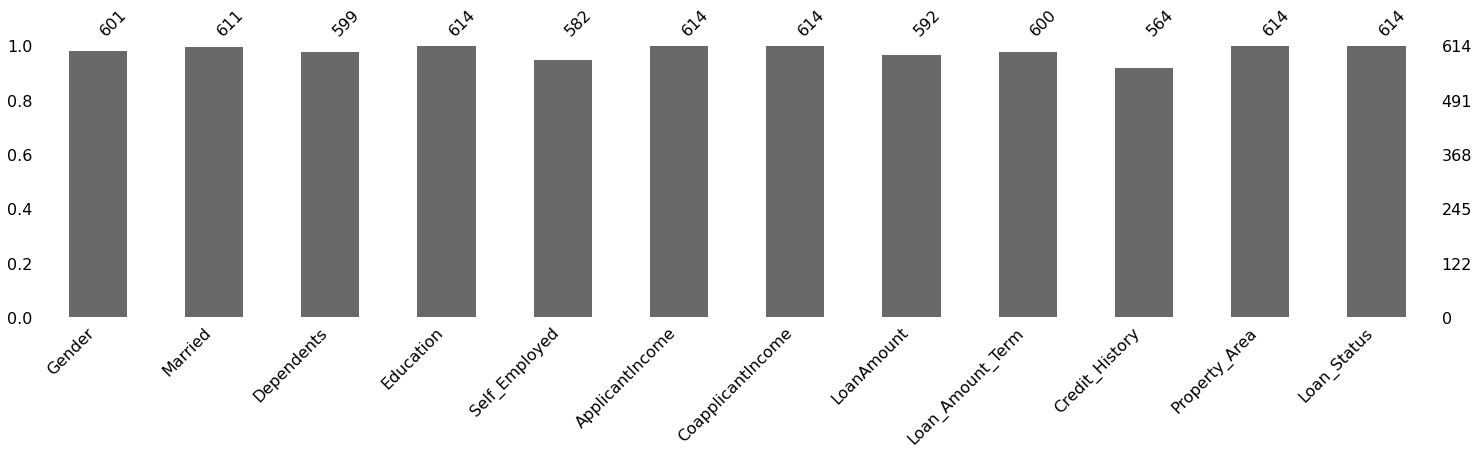

In [13]:
missingno.bar(df, figsize = (25,5))

We are able to depict the missing values information in a bar plot format where we can clearly see that there are null data present in below columns:

- Gender
- Married
- Dependents
- Self_Employed
- LoanAmount
- Loan_Amount_Term
- Credit_History

In [14]:
print(f"Rows and Columns before dropping duplicates: ", df.shape)
df.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df.shape)

Rows and Columns before dropping duplicates:  (614, 12)
Rows and Columns after dropping duplicates:  (614, 12)


With the drop_duplicates option we can always get rid of duplicate data especially on larger datasets. Here we see there are no duplicate rows therefore no data was lost in the above process.

In [15]:
df.nunique().to_frame("Unique Values")

,Unique Values
Gender,2
Married,2
Dependents,4
Education,2
Self_Employed,2
ApplicantIncome,505
CoapplicantIncome,287
LoanAmount,203
Loan_Amount_Term,10
Credit_History,2


The nunique method lists down the number of all the unique data present in each column of our dataset.

In [18]:
for col in object_datatype:
    print(col)
    print(df[col].value_counts())
    print("="*60)

Gender
Male      489
Female    112
Name: Gender, dtype: int64
Married
Yes    398
No     213
Name: Married, dtype: int64
Dependents
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
Self_Employed
No     500
Yes     82
Name: Self_Employed, dtype: int64
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
Loan_Status
Y    422
N    192
Name: Loan_Status, dtype: int64


In the above cell we are taking a look at all the unique values of object data type columns. While eye balling the values we were able to see the categories in each columns and the number of rows that cover those data in our entire dataframe.

## Filling all the missing values

In [19]:
# filling continous data columns with the mean value of that column
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean())

# filling categorical data columns with the mode value of that column
df['Credit_History']=df['Credit_History'].fillna(df['Credit_History'].mode()[0])
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])

I have filled all the missing values in continous data columns using the mean value of those columns and all the missing data in categorical columns with the mode of those columns.

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


<AxesSubplot:>

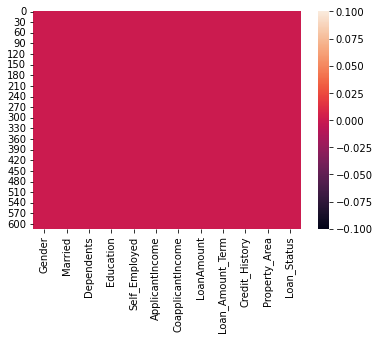

In [22]:
#checking the null values
print(df.isnull().sum())
sns.heatmap(df.isnull())

We can see that all the missing data has been filled successfully into our dataset.

In [23]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.000000,0.855049
std,6109.041673,2926.248369,84.037468,64.372489,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


Hence counts are equal now

# Data Visualization

In [21]:
print(f"Object Data Type Column Names: \n", object_datatype)
print(f"\nNumeric Data Type Column Names: \n", number_datatype)

Object Data Type Column Names: 
 ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

Numeric Data Type Column Names: 
 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


Lisiting out the column names for object datatype and numeric datatype respectively.

### Univariate Analysis

### Visualizing the Categorical columns

Y    422
N    192
Name: Loan_Status, dtype: int64


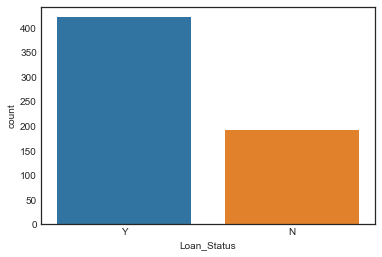

In [25]:
# Visualizing the label (Loan Status)
print(df["Loan_Status"].value_counts())
sns.countplot(df["Loan_Status"])
plt.show()

As we have seen earlier aswell, this data is imbalanced. The Y is higher to a considerable amount then N, we will SMOTE it going forward.

Male      502
Female    112
Name: Gender, dtype: int64


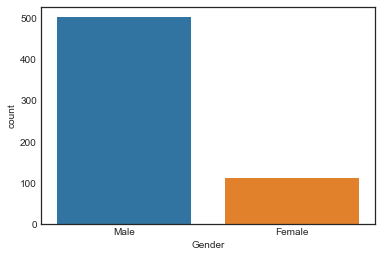

In [26]:
#Gender
print(df["Gender"].value_counts())
sns.countplot(df["Gender"])
plt.show()

The applicants in males are considerably higher.

Yes    401
No     213
Name: Married, dtype: int64


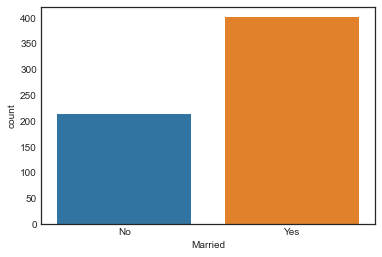

In [27]:
#Married
print(df["Married"].value_counts())
sns.countplot(df["Married"])
plt.show()

Married loan applicant are comparitevely higher

0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64


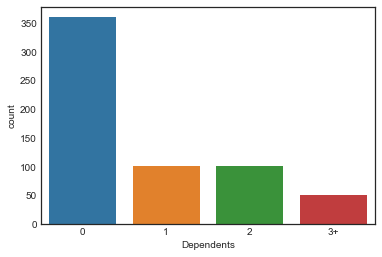

In [28]:
#Dependents
print(df["Dependents"].value_counts())
sns.countplot(df["Dependents"])
plt.show()

The applicants who have 0 dependents have high counts and the applicants having more than 3 dependents counts are very less.

Graduate        480
Not Graduate    134
Name: Education, dtype: int64


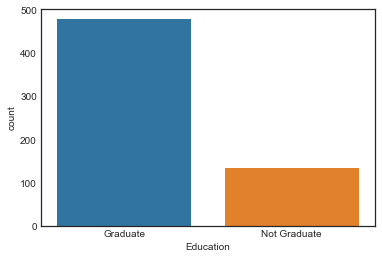

In [29]:
# Education
print(df["Education"].value_counts())
sns.countplot(df["Education"])
plt.show()

Graduate applicants are comparitively higher

No     532
Yes     82
Name: Self_Employed, dtype: int64


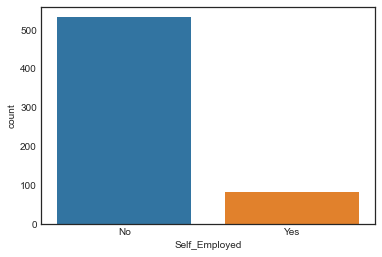

In [30]:
#Self_Employed
print(df["Self_Employed"].value_counts())
sns.countplot(df["Self_Employed"])
plt.show()

Applicant who are not self employeed are comparitively higher

1.0    525
0.0     89
Name: Credit_History, dtype: int64


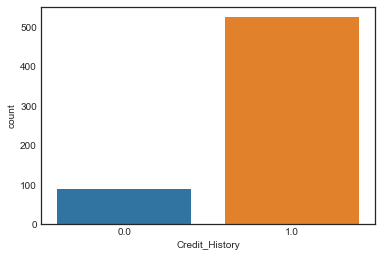

In [31]:
# Credit_History
print(df["Credit_History"].value_counts())
sns.countplot(df["Credit_History"])
plt.show()

Most of the applicants who have credit history 1 are high in numbers.

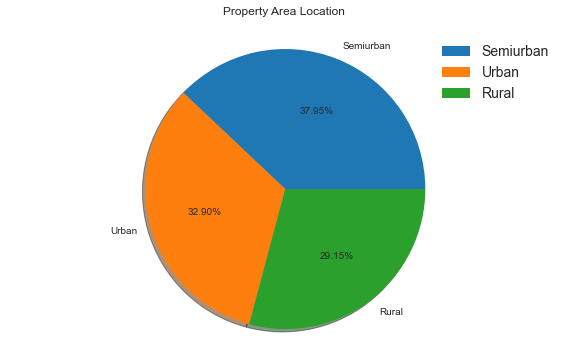

In [32]:
plt.figure(figsize=(8,5))
plt.pie(df['Property_Area'].value_counts(), labels=df['Property_Area'].value_counts().index, 
        shadow=True, autopct='%1.2f%%')
plt.title('Property Area Location\n')
plt.legend(prop={'size':14})
plt.axis('equal')
plt.tight_layout()
plt.show()

In the above pie chart we can see that 37.95% rows are covered by semi urban area type, 32.90% rows are covered by urban area type and 29.15% rows are covered by rural area type in our property area column.

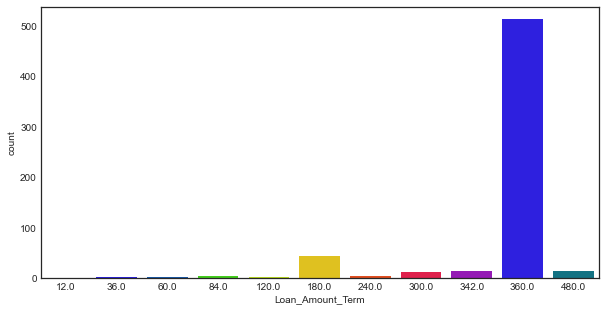

In [33]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Loan_Amount_Term'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")
    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    pass

In the above count plot we can see that the highest number of rows are covered by the value 360.0 in the "Loan_Amount_Term" column.

### Multivariate Analysis

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

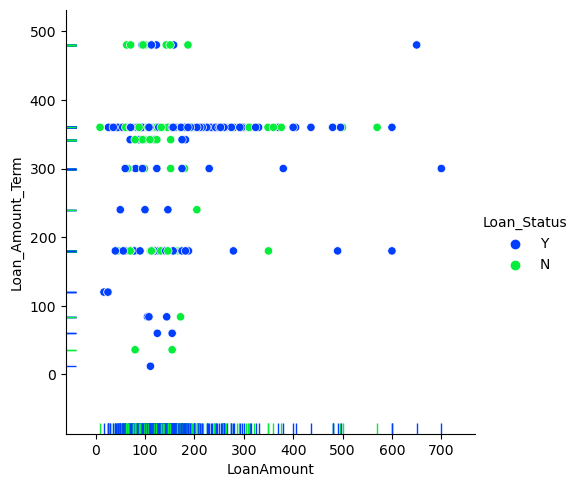

In [35]:
plt.style.use('seaborn-bright')
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Loan_Status', legend=False)

In the loan amount vs loan amount term plot we can see that most of the data points are accumulated for 180, 300, 340, 360 and 480 terms while loan amount ranging from 50-250 for a term of 480 mostly seems to be getting rejected than approved.

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Amount_Term'>

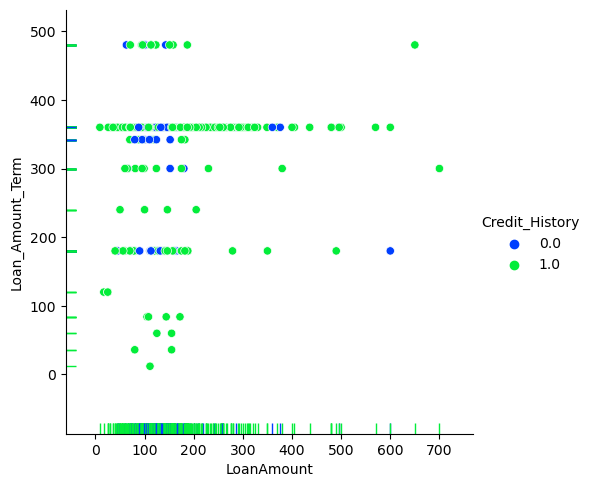

In [36]:
sns.relplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='Loan_Amount_Term', hue='Credit_History', legend=False)

In the above plot we can see that in loan amount vs loan amount term datapoints most of the values already have a credit history to showcase.

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

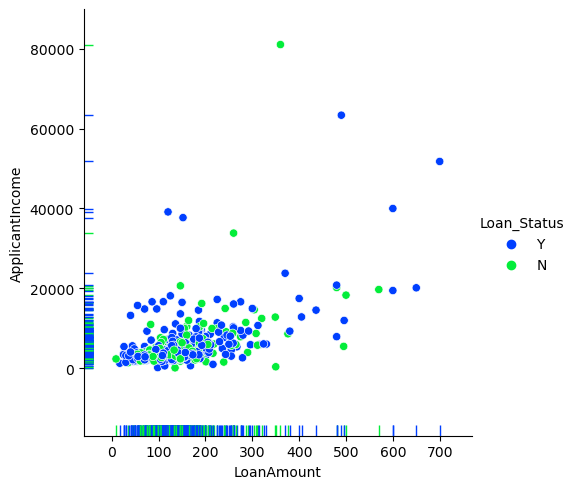

In [37]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Loan_Status', legend=False)

In the above plot we can see that most of the data points are converged near the range 0-20000 data for Applicant Income for mostly loan amount between 0-400

<AxesSubplot:xlabel='LoanAmount', ylabel='ApplicantIncome'>

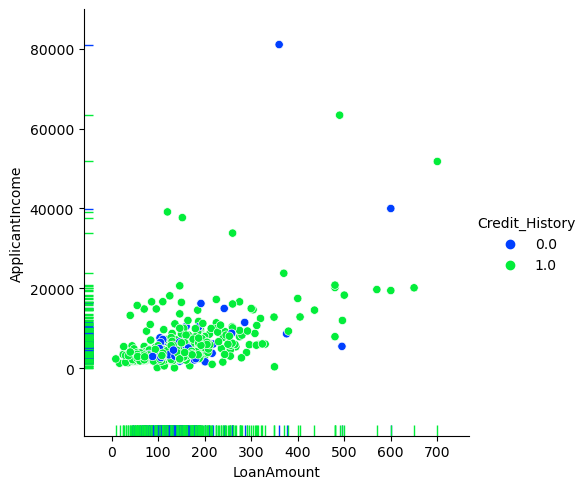

In [38]:
sns.relplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='ApplicantIncome', hue='Credit_History', legend=False)

In the above plot we see that most of the data points have their credit history available and the values are converged between 0-20000 for applicant income and 0-400 for loan amount data

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

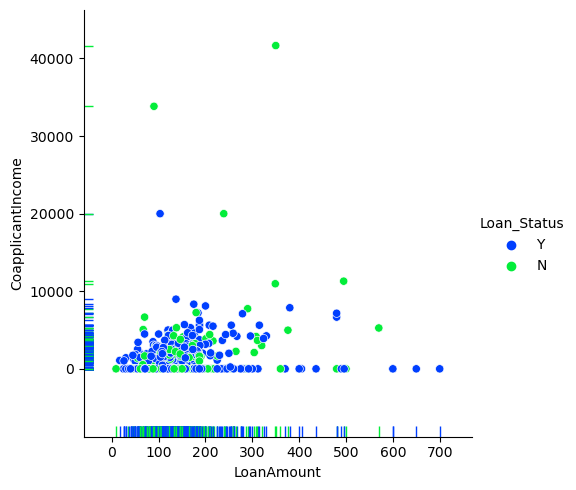

In [39]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Loan_Status', legend=False)

In the above plot we see the co applicant income vs loan amount data points where in co applicants with higher income are mostly denied loan where most data values are converged between 0-10000 for co applicant income and 0-300 for loan amount data

<AxesSubplot:xlabel='LoanAmount', ylabel='CoapplicantIncome'>

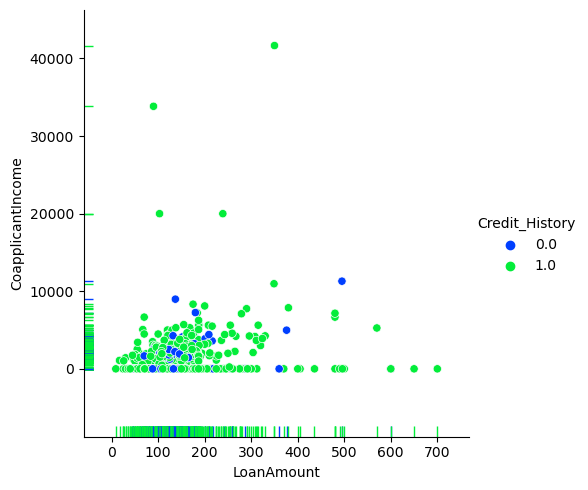

In [40]:
sns.relplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History')
sns.rugplot(data=df, x='LoanAmount', y='CoapplicantIncome', hue='Credit_History', legend=False)

In the above plot we can see that most of the data points are accumulated between 0-10000 for co applicant income and 0-350 for loan amount data and most of these data points have a credit history available for them

### Pairplot

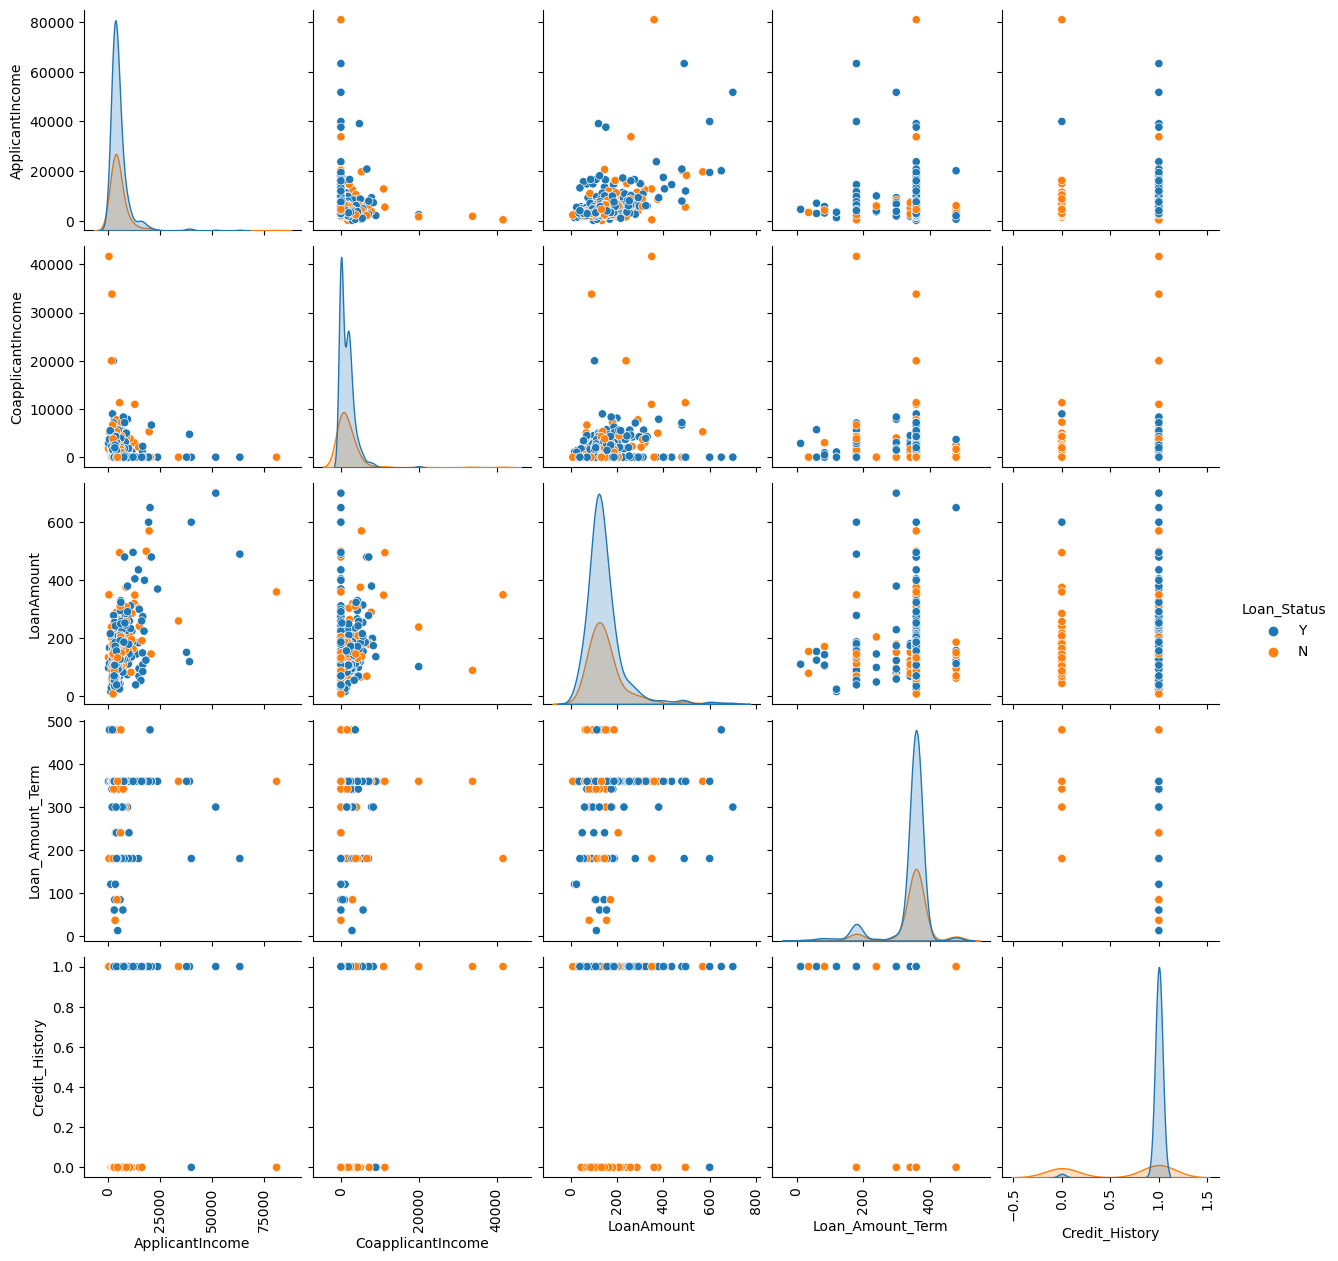

In [41]:
plt.style.use('default')
g = sns.pairplot(df, hue='Loan_Status', diag_kind='kde')
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=90)
plt.show()

I have generated the above pairplot for our continous data columns that shows us how the data points are distributed in each of the numeric datatype columns.

## Encoding the categorical object datatype columns

In [42]:
# Label Encoder
le = LabelEncoder()
df["Loan_Status"] = le.fit_transform(df["Loan_Status"])
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,1


I have used LabelEncoder to convert the object data type in our label column "Loan_Status" to a numerical format.

In [43]:
# Ordinal Encoder
oe = OrdinalEncoder()
df['Gender'] = oe.fit_transform(df['Gender'].values.reshape(-1,1))
df['Married'] = oe.fit_transform(df['Married'].values.reshape(-1,1))
df['Dependents'] = oe.fit_transform(df['Dependents'].values.reshape(-1,1))
df['Education'] = oe.fit_transform(df['Education'].values.reshape(-1,1))
df['Self_Employed'] = oe.fit_transform(df['Self_Employed'].values.reshape(-1,1))
df['Property_Area'] = oe.fit_transform(df['Property_Area'].values.reshape(-1,1))
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1
1,1.0,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0
2,1.0,1.0,0.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1
3,1.0,1.0,0.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1
4,1.0,0.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1


I could have used one hot encoder here but I preferred to use OrdinalEncoder to ensure that the number of columns do not get increased unnecessarily.

In [45]:
df.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

checking that after applying the enconding techniques and ensuring that there are no null values present in them.

## Checking for Outliers

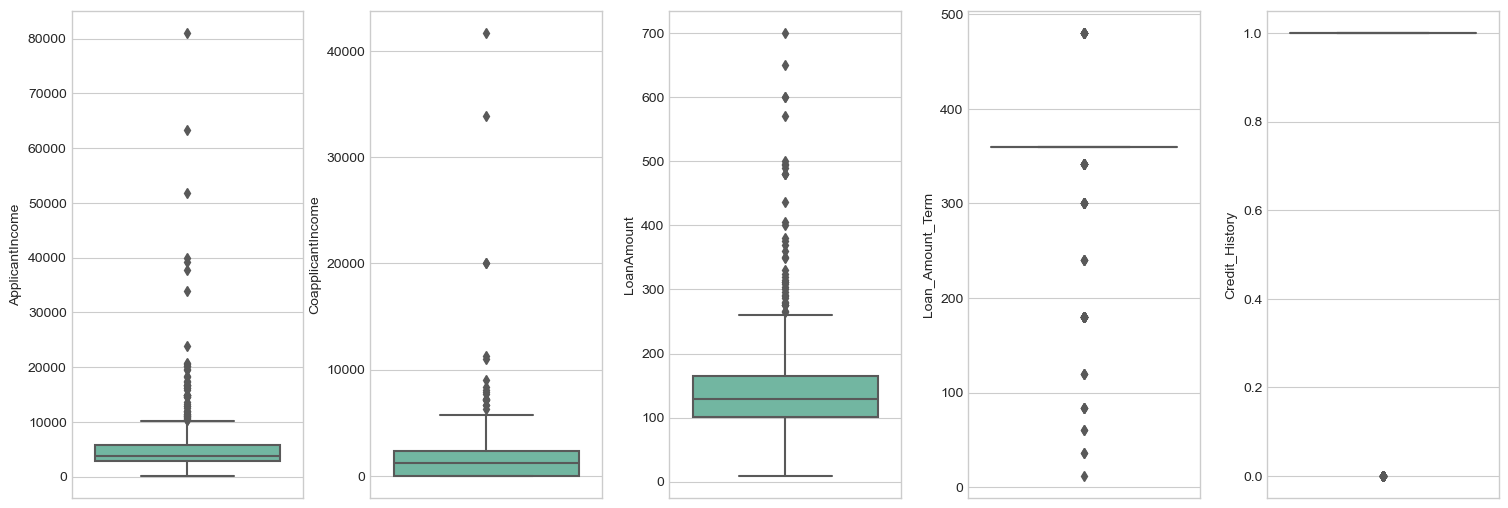

In [46]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[number_datatype].items():
    sns.boxplot(y=col, data=df, ax=ax[index], palette="Set2")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of box plot we can see the outlier details present in our numerical data columns which will need to be treated.

## Checking for Skewness

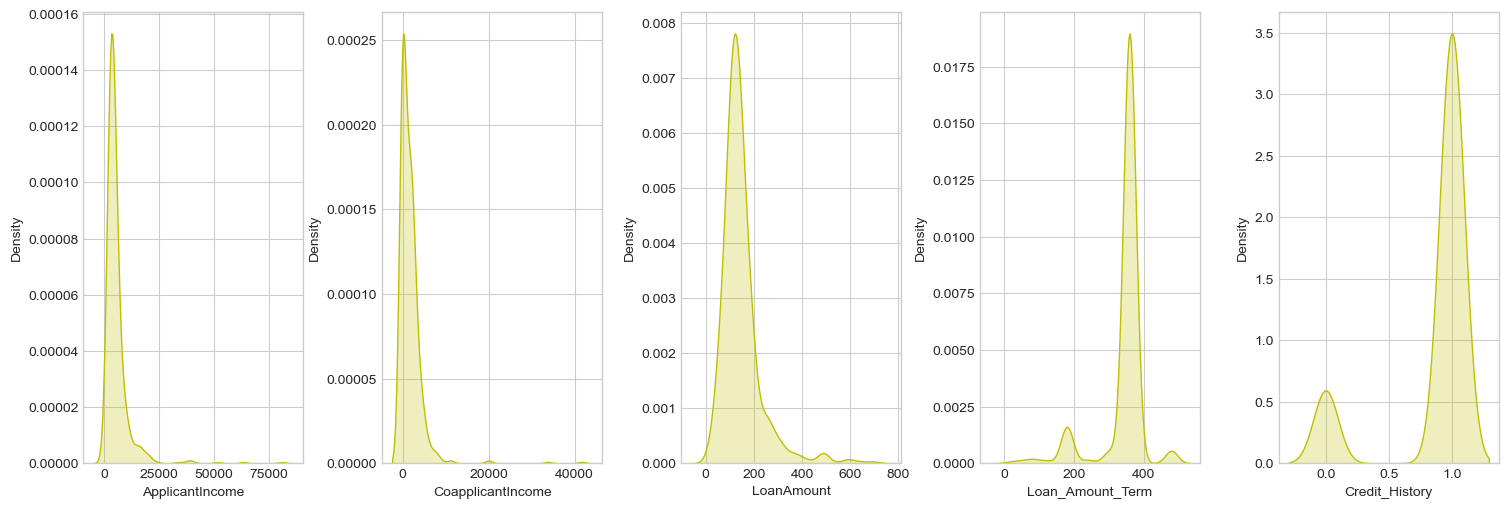

In [47]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[number_datatype].items():
    sns.distplot(value, ax=ax[index], hist=False, color="y", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of distribution plot we can see the skewness details present in our numerical data columns which will need to be treated.

## Histogram

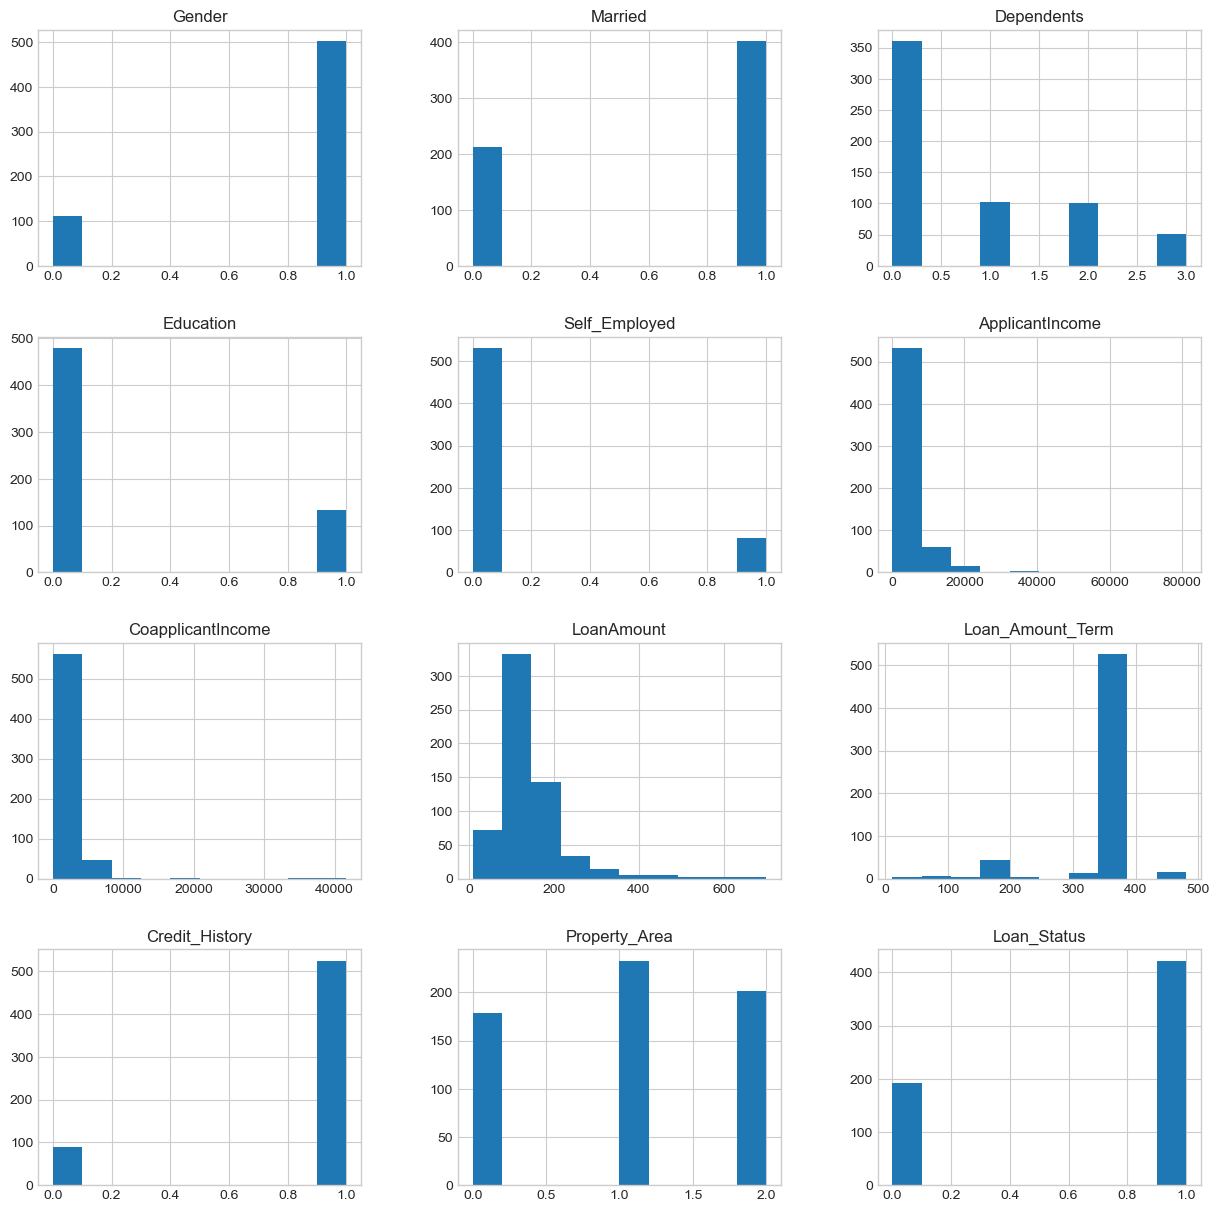

In [48]:
df.hist(figsize=(15,15))
plt.show()

I have generated a histogram for all our dataset columns after applying enconding and converting object datatype to numeric datatype values.

## Checking Correlation

- Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.
- Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

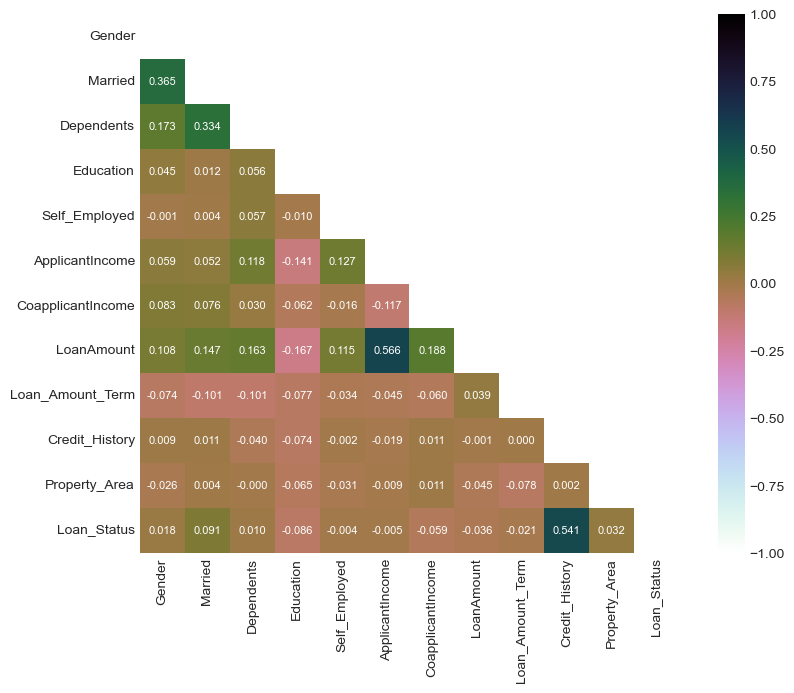

In [49]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, cmap="cubehelix_r", mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In the above heatmap we can see the correlation details plus we can determine that there is no multicollinearity issue between our columns.

In [51]:
df.corr().Loan_Status.sort_values()

Education           -0.085884
CoapplicantIncome   -0.059187
LoanAmount          -0.036416
Loan_Amount_Term    -0.020974
ApplicantIncome     -0.004710
Self_Employed       -0.003700
Dependents           0.010118
Gender               0.017987
Property_Area        0.032112
Married              0.091478
Credit_History       0.540556
Loan_Status          1.000000
Name: Loan_Status, dtype: float64

### Correlation Bar Plot comparing features with our label

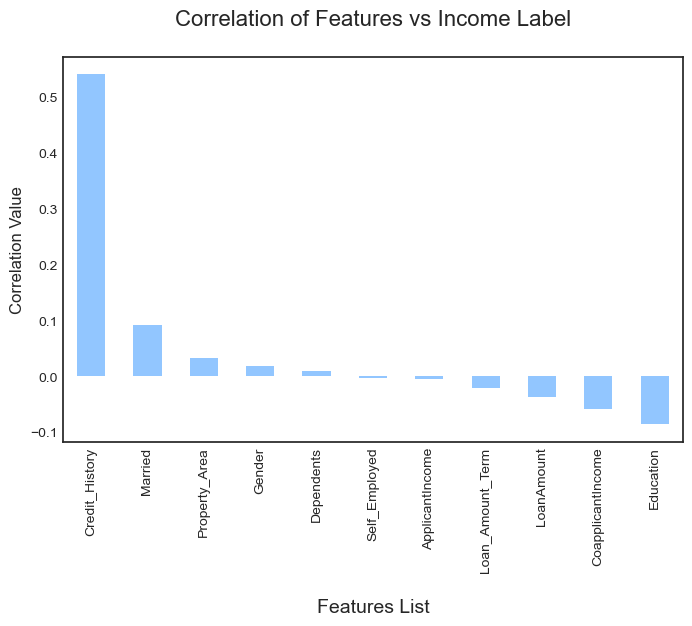

In [52]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(8,5))
df_corr['Loan_Status'].sort_values(ascending=False).drop('Loan_Status').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

Since the heatmap was not able to give us a clear picture on positive and negative correlation columns we have generated this bar plot and we see that columns loan amount term, loan amount, co applicant income and education are negatively correlated while all the remaining feature columns are positively correlated with our label column.

## Data Preprocessing

### Using Z Score to remove outliers

In [53]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

print ("Shape of the dataframe before removing outliers: ", df.shape)
print ("Shape of the dataframe after removing outliers: ", df1.shape)
print ("Percentage of data loss post outlier removal: ", (df.shape[0]-df1.shape[0])/df.shape[0]*100)

df=df1.copy() # reassigning the changed dataframe name to our original dataframe name

Shape of the dataframe before removing outliers:  (614, 12)
Shape of the dataframe after removing outliers:  (577, 12)
Percentage of data loss post outlier removal:  6.026058631921824


I have used the Z score method to remove the outliers and the percent of data lost is 6.026% which is below 10 percent which is acceptable.

In [55]:
df.skew().sort_values()

Loan_Amount_Term    -2.077031
Credit_History      -1.976043
Gender              -1.622920
Loan_Status         -0.822635
Married             -0.630211
Property_Area       -0.055332
Dependents           1.052106
LoanAmount           1.113132
Education            1.306588
CoapplicantIncome    1.350517
ApplicantIncome      2.148522
Self_Employed        2.252848
dtype: float64

With the skew method we see that there are columns present in our dataset that are above the acceptable range of +/-0.5 value even after outliers removal.

### Transformation for removing skewness

In [56]:
for col in number_datatype:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

I have applied Log Transformation on our numerical datatype columns to ensure that we do not have skewness in our dataset.

In [57]:
df.skew().sort_values()

Loan_Amount_Term    -2.077031
Credit_History      -1.976043
Gender              -1.622920
Loan_Status         -0.822635
LoanAmount          -0.697883
Married             -0.630211
CoapplicantIncome   -0.216757
ApplicantIncome     -0.204913
Property_Area       -0.055332
Dependents           1.052106
Education            1.306588
Self_Employed        2.252848
dtype: float64

We have managed to reduce the skewness from our numerical columns which can be seen above while we have ignored the skewness and outlier details for our categorical columns.

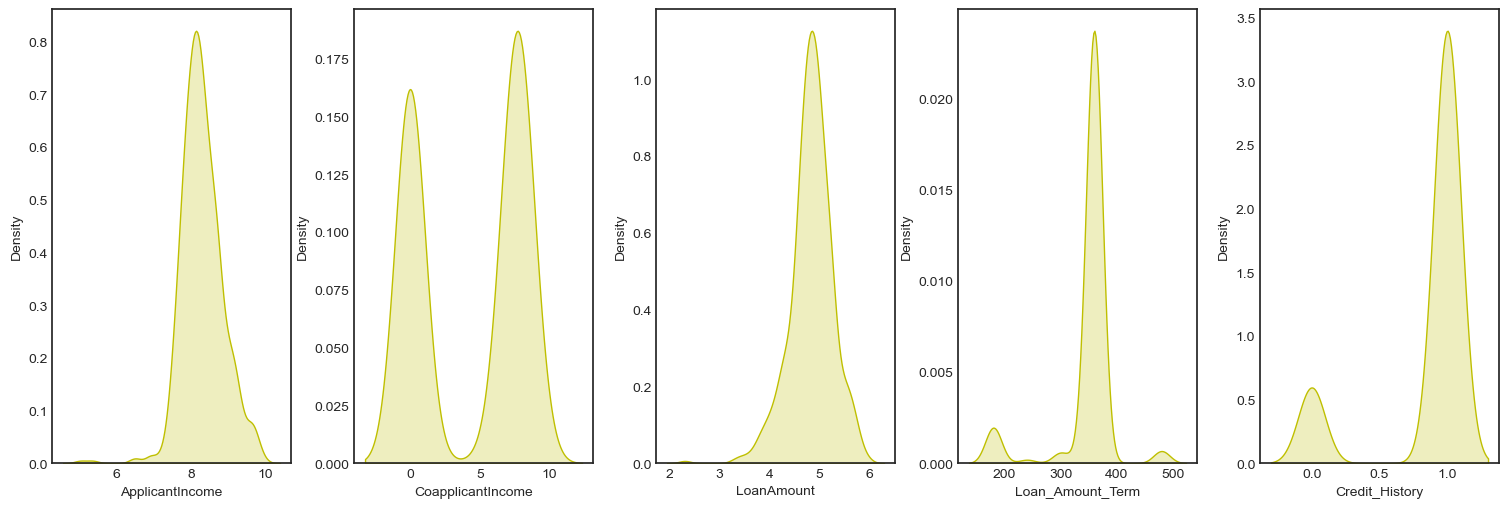

In [58]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[number_datatype].items():
    sns.distplot(value, ax=ax[index], hist=False, color="y", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

the distribution looks better now after skewness removal.

In [59]:
df.corr()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.000000,0.378997,0.188162,0.045696,-0.006207,0.060302,0.235133,0.177720,-0.104412,0.013172,-0.026340,0.017408
Married,0.378997,1.000000,0.329900,0.024817,-0.015779,-0.026283,0.339399,0.186356,-0.127289,0.019308,0.010595,0.089026
Dependents,0.188162,0.329900,1.000000,0.069814,0.044543,0.106349,0.007373,0.127272,-0.083756,-0.020288,0.002327,0.017872
Education,0.045696,0.024817,0.069814,1.000000,-0.007139,-0.174609,0.054682,-0.110204,-0.094628,-0.075217,-0.068596,-0.092658
Self_Employed,-0.006207,-0.015779,0.044543,-0.007139,1.000000,0.207418,-0.089466,0.113287,-0.033346,-0.016390,-0.028253,-0.026525
ApplicantIncome,0.060302,-0.026283,0.106349,-0.174609,0.207418,1.000000,-0.362495,0.405411,-0.069412,0.027449,-0.010603,-0.001761
CoapplicantIncome,0.235133,0.339399,0.007373,0.054682,-0.089466,-0.362495,1.000000,0.196642,0.002962,0.008071,-0.072402,0.081455
LoanAmount,0.177720,0.186356,0.127272,-0.110204,0.113287,0.405411,0.196642,1.000000,0.052385,-0.012837,-0.103225,-0.023549
Loan_Amount_Term,-0.104412,-0.127289,-0.083756,-0.094628,-0.033346,-0.069412,0.002962,0.052385,1.000000,0.034027,-0.058990,-0.018144
Credit_History,0.013172,0.019308,-0.020288,-0.075217,-0.016390,0.027449,0.008071,-0.012837,0.034027,1.000000,-0.008121,0.560936


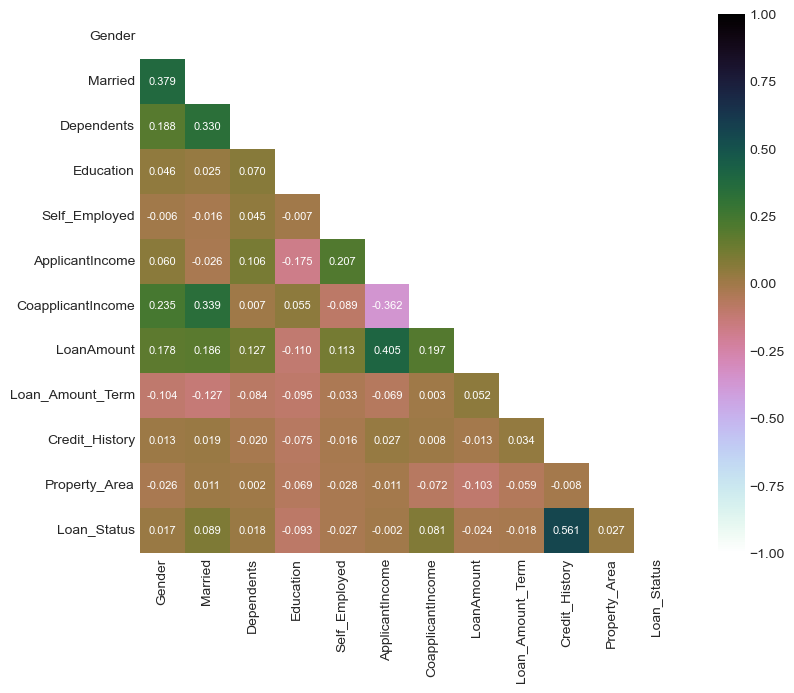

In [60]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, cmap="cubehelix_r", mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [61]:
df.corr().Loan_Status.sort_values()

Education           -0.092658
Self_Employed       -0.026525
LoanAmount          -0.023549
Loan_Amount_Term    -0.018144
ApplicantIncome     -0.001761
Gender               0.017408
Dependents           0.017872
Property_Area        0.026507
CoapplicantIncome    0.081455
Married              0.089026
Credit_History       0.560936
Loan_Status          1.000000
Name: Loan_Status, dtype: float64

we can see the above values for correlation after encoding, transformation and outlier removal.

## Splitting the dataset into Features and Target

In [69]:
X = df.drop('Loan_Status', axis=1)
Y = df['Loan_Status']

In [70]:
X.shape

(577, 11)

In [71]:
Y.shape

(577,)

### Resolving the class imbalance issue SMOTE

I have bifurcated the dataset into features and labels where X represents all the feature columns and Y represents the target label column.

In [72]:
Y.value_counts()

1    398
0    179
Name: Loan_Status, dtype: int64

Listing the values of our label column to count the number of rows occupied by each category. This indicates class imbalance that we will need to fix by using the oversampling method.

In [73]:
# adding samples to make all the categorical label values same

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

In [74]:
Y.value_counts()

1    398
0    398
Name: Loan_Status, dtype: int64

After applying over sampling we are once again listing the values of our label column to cross verify the updated information. Here we see that we have successfully resolved the class imbalance problem and now all the categories have same data ensuring that the machine learning model does not get biased towards one category.

In [75]:
X.shape

(796, 11)

In [76]:
Y.shape

(796,)

## Feature Scaling

Scaling the independant variable (X) to get all the columns in a standard scale

In [77]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.500696,-1.301462,-0.709734,-0.567959,-0.357593,0.762326,-1.081661,0.408893,0.23337,0.56797,1.201596
1,0.500696,0.800683,0.337507,-0.567959,-0.357593,0.291798,0.821161,0.077614,0.23337,0.56797,-1.325639
2,0.500696,0.800683,-0.709734,-0.567959,2.953345,-0.525557,-1.081661,-1.549033,0.23337,0.56797,1.201596
3,0.500696,0.800683,-0.709734,1.842542,-0.357593,-0.814213,0.937316,-0.081351,0.23337,0.56797,1.201596
4,0.500696,-1.301462,-0.709734,-0.567959,-0.357593,0.811497,-1.081661,0.316016,0.23337,0.56797,1.201596


Scaled the data and standardised all the columns to avoid any bias in the modeling.

### Checking VIF values to solve multicollinearity

In [83]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [84]:
# Finding varience inflation factor in each scaled column
def calc_vif(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF values"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    return(vif)

In [85]:
calc_vif(X)

,Features,VIF values
0,Gender,1.216844
1,Married,1.505849
2,Dependents,1.187183
3,Education,1.096630
4,Self_Employed,1.056895
5,ApplicantIncome,1.699585
6,CoapplicantIncome,1.694368
7,LoanAmount,1.582593
8,Loan_Amount_Term,1.090027
9,Credit_History,1.015909


Here we can see that all the columns have VIF Factor of less than 5 hence there is no multicollinearity present.

Now the Dataset is ready for Machine Learning

# Machine Learning

### Finding best random state

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
lr = LogisticRegression()

For 0.2 test size

In [91]:
maxAccu = 0   # maximum accuracy
maxRS = 0     # best random state value for which max accuracy is achieved

for i in range(1, 1000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    lr=LogisticRegression()
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    acc_score = (accuracy_score(y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 84.375 on Random State 68


For 0.25 test size

In [92]:
maxAccu = 0   # maximum accuracy
maxRS = 0     # best random state value for which max accuracy is achieved

for i in range(1, 1000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LogisticRegression()
    lr.fit(x_train, y_train)
    pred = lr.predict(x_test)
    acc_score = (accuracy_score(y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 82.91457286432161 on Random State 261


Hence the best random state is 68 comparing the above

In [93]:
# Importing required libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### train_test_split

In [95]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=68)

## Feature importance bar graph

,Importance
Features,
Credit_History,0.260
ApplicantIncome,0.176
LoanAmount,0.172
CoapplicantIncome,0.104
Property_Area,0.070
Dependents,0.053
Married,0.044
Education,0.036
Loan_Amount_Term,0.034


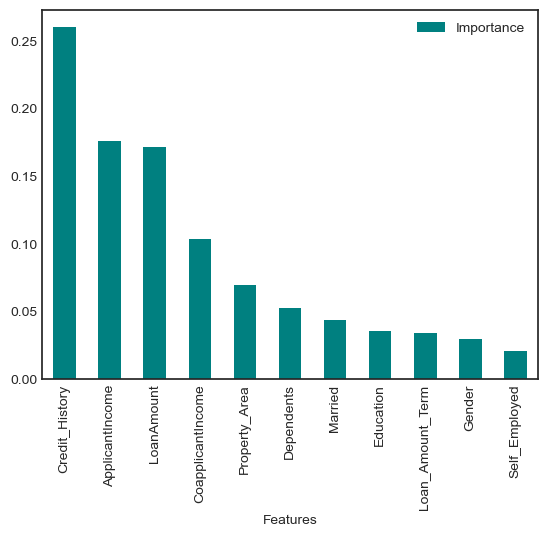

In [96]:
rf=RandomForestClassifier()
rf.fit(x_train, y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

Here with the help of RandomForestClassifier we are able to list down the importance or priority given to a column as per it's involvement or weightage in predicting our label.

In [98]:
# creating a function to run all the classifiers

def classifier(model, X, Y):
    x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=68) 
    
    # Training the model
    model.fit(x_train, y_train)
    
    # Predicting y_test
    pred = model.predict(x_test)
    
    # Accuracy Score
    acc_score = (accuracy_score(y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # Classification Report
    class_report = classification_report(y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

### Logistic Regression

In [99]:
model = LogisticRegression()
classifier(model, X, Y)

Accuracy Score: 84.375

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.66      0.77        65
           1       0.81      0.97      0.88        95

    accuracy                           0.84       160
   macro avg       0.87      0.81      0.83       160
weighted avg       0.86      0.84      0.84       160

Cross Validation Score: 75.13207547169813

Accuracy Score - Cross Validation Score is 9.24292452830187


### Naive Bayes

In [100]:
model = GaussianNB()
classifier(model, X, Y)

Accuracy Score: 80.0

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.58      0.70        65
           1       0.77      0.95      0.85        95

    accuracy                           0.80       160
   macro avg       0.83      0.77      0.78       160
weighted avg       0.82      0.80      0.79       160

Cross Validation Score: 72.99606918238993

Accuracy Score - Cross Validation Score is 7.003930817610069


### SVC Classifier

In [101]:
model = SVC(kernel='rbf')
classifier(model, X, Y)

Accuracy Score: 83.75

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.79        65
           1       0.83      0.91      0.87        95

    accuracy                           0.84       160
   macro avg       0.84      0.82      0.83       160
weighted avg       0.84      0.84      0.84       160

Cross Validation Score: 77.89622641509435

Accuracy Score - Cross Validation Score is 5.853773584905653


In [102]:
model = SVC(kernel='linear')
classifier(model, X, Y)

Accuracy Score: 81.25

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.55      0.71        65
           1       0.76      0.99      0.86        95

    accuracy                           0.81       160
   macro avg       0.87      0.77      0.78       160
weighted avg       0.85      0.81      0.80       160

Cross Validation Score: 73.12106918238995

Accuracy Score - Cross Validation Score is 8.128930817610055


In [103]:
model = SVC(kernel='poly')
classifier(model, X, Y)

Accuracy Score: 83.125

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.71      0.77        65
           1       0.82      0.92      0.87        95

    accuracy                           0.83       160
   macro avg       0.84      0.81      0.82       160
weighted avg       0.83      0.83      0.83       160

Cross Validation Score: 76.00943396226415

Accuracy Score - Cross Validation Score is 7.115566037735846


### Decision Tree Classifier

In [104]:
model = DecisionTreeClassifier()
classifier(model, X, Y)

Accuracy Score: 78.75

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.83      0.76        65
           1       0.87      0.76      0.81        95

    accuracy                           0.79       160
   macro avg       0.78      0.79      0.78       160
weighted avg       0.80      0.79      0.79       160

Cross Validation Score: 75.5125786163522

Accuracy Score - Cross Validation Score is 3.237421383647799


### KNeighbors Classifier

In [105]:
model = KNeighborsClassifier()
classifier(model, X, Y)

Accuracy Score: 82.5

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.83      0.79        65
           1       0.88      0.82      0.85        95

    accuracy                           0.82       160
   macro avg       0.82      0.83      0.82       160
weighted avg       0.83      0.82      0.83       160

Cross Validation Score: 76.89150943396227

Accuracy Score - Cross Validation Score is 5.60849056603773


### SGD Classifier

In [106]:
model = SGDClassifier()
classifier(model, X, Y)

Accuracy Score: 72.5

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.69      0.67        65
           1       0.78      0.75      0.76        95

    accuracy                           0.73       160
   macro avg       0.72      0.72      0.72       160
weighted avg       0.73      0.72      0.73       160

Cross Validation Score: 65.45361635220125

Accuracy Score - Cross Validation Score is 7.0463836477987485


### Random Forest Classifier

In [107]:
model = RandomForestClassifier(random_state=68)
classifier(model, X, Y)

Accuracy Score: 90.625

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88        65
           1       0.91      0.94      0.92        95

    accuracy                           0.91       160
   macro avg       0.91      0.90      0.90       160
weighted avg       0.91      0.91      0.91       160

Cross Validation Score: 84.31132075471697

Accuracy Score - Cross Validation Score is 6.313679245283026


In [108]:
model = RandomForestClassifier()
classifier(model, X, Y)

Accuracy Score: 91.25

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        65
           1       0.91      0.95      0.93        95

    accuracy                           0.91       160
   macro avg       0.91      0.90      0.91       160
weighted avg       0.91      0.91      0.91       160

Cross Validation Score: 84.68867924528303

Accuracy Score - Cross Validation Score is 6.561320754716974


### ExtraTrees Classifier

In [109]:
model = ExtraTreesClassifier(random_state=68)
classifier(model, X, Y)

Accuracy Score: 88.125

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86        65
           1       0.91      0.88      0.90        95

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160

Cross Validation Score: 83.93081761006289

Accuracy Score - Cross Validation Score is 4.194182389937112


In [110]:
model = ExtraTreesClassifier()
classifier(model, X, Y)

Accuracy Score: 88.125

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86        65
           1       0.91      0.88      0.90        95

    accuracy                           0.88       160
   macro avg       0.88      0.88      0.88       160
weighted avg       0.88      0.88      0.88       160

Cross Validation Score: 84.3058176100629

Accuracy Score - Cross Validation Score is 3.8191823899370974


### AdaBoost Classifier

In [111]:
model = AdaBoostClassifier()
classifier(model, X, Y)

Accuracy Score: 83.75

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.80        65
           1       0.87      0.85      0.86        95

    accuracy                           0.84       160
   macro avg       0.83      0.83      0.83       160
weighted avg       0.84      0.84      0.84       160

Cross Validation Score: 76.01572327044026

Accuracy Score - Cross Validation Score is 7.734276729559738


### Gradient Boosting Classifier

In [112]:
model = GradientBoostingClassifier()
classifier(model, X, Y)

Accuracy Score: 88.75

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86        65
           1       0.89      0.93      0.91        95

    accuracy                           0.89       160
   macro avg       0.89      0.88      0.88       160
weighted avg       0.89      0.89      0.89       160

Cross Validation Score: 80.41352201257862

Accuracy Score - Cross Validation Score is 8.336477987421375


Comparing all the above the RandomForestClassifier gives the best results since the Accuracy Score - Cross Validation Score is the least along with higher Cross Validation Score and the highest Accuracy Score comparing all the models.

# Hyper Parameter Tuning

In [113]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.20,random_state=68)

In [114]:
x_test.shape

(160, 11)

In [115]:
y_test.shape

(160,)

In [116]:
x_train.shape

(636, 11)

In [117]:
y_train.shape

(636,)

In [121]:
#RandomForestClassifier?

In [122]:
# creating parameters list to pass into GridSearchCV

parameters = {'criterion' : ['gini', 'entropy'],
              'max_features' : ['auto', 'sqrt', 'log2'],
              'n_jobs' : [5, 10],
              'random_state' : [None, 68, 261]}

In [123]:
GCV = GridSearchCV(RandomForestClassifier(), parameters, cv=5)

In [124]:
GCV.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_jobs': [5, 10], 'random_state': [None, 68, 261]})

In [125]:
GCV.best_params_      # printing best parameters found by GridSearchCV

{'criterion': 'gini',
 'max_features': 'log2',
 'n_jobs': 5,
 'random_state': None}

We got the best parameters using Gridsearch CV

In [130]:
final_modelc = RandomForestClassifier(criterion = 'gini', max_features = 'log2', n_jobs = 5, random_state = None)   # final model with best parameters

In [131]:
final_fitc = final_modelc.fit(x_train,y_train)   # final fit

In [132]:
final_predc = final_modelc.predict(x_test)   # predicting with best parameters

In [133]:
best_acc_score = (accuracy_score(y_test, final_predc))*100    # checking accuracy score
print("The Accuracy Score for the Best Model is ", best_acc_score)

The Accuracy Score for the Best Model is  90.625


We successfully performed the Hyper Parameter Tuning on the Final Model.

In [134]:
# Final Cross Validation Score
final_cv_score = (cross_val_score(final_modelc, X, Y, cv=5).mean())*100
print("Cross Validation Score:", final_cv_score)

Cross Validation Score: 83.80738993710692


We got final accuracy score of 90.625% and Cross Validation Score of 83.807% which is good

In [135]:
# Final Classification Report
final_class_report = classification_report(y_test, final_predc)
print("\nClassification Report:\n", final_class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88        65
           1       0.90      0.95      0.92        95

    accuracy                           0.91       160
   macro avg       0.91      0.90      0.90       160
weighted avg       0.91      0.91      0.91       160



## Confusion Matrix

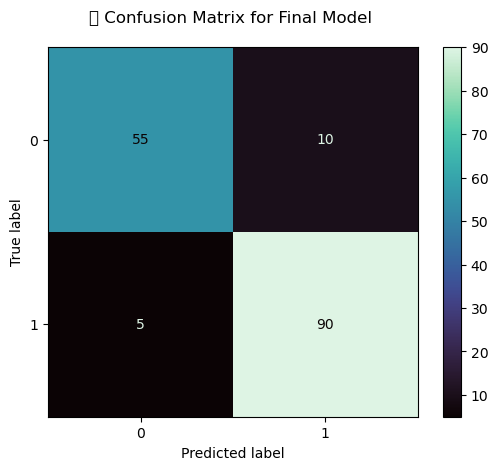

In [136]:
plt.style.use('default')
class_names = df.columns
metrics.plot_confusion_matrix(final_modelc, x_test, y_test, cmap='mako')
plt.title('\t Confusion Matrix for Final Model \n')
plt.show()

With the help of above confusion matrix I am able to understand the number of times I got the correct outputs and the number of times my ML model missed to provide the correct prediction (depicting in the black boxes).

# AUC ROC curve

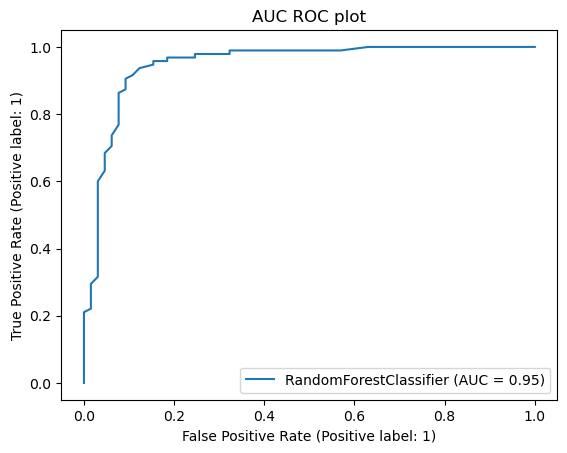

In [137]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(final_modelc, x_test, y_test)
plt.title("AUC ROC plot")
plt.show()

We got final accuracy score of 90.625% and Cross Validation Score of 83.807% and also AUC Score of 0.95 which is really good.

# Saving the model in pickle Format

In [138]:
# pickeling or serialization of a file
import pickle
filename = 'Loan_Application_Status_Final_Model.pkl'
pickle.dump(final_modelc, open(filename, 'wb'))

# Prediction Conclusion:

In [139]:
import numpy as np
ac=np.array(y_test)
predictedc=np.array(final_modelc.predict(x_test))
df_comparisonc = pd.DataFrame({"original":ac,"predicted":predictedc},index= range(len(ac)))
df_comparisonc

,original,predicted
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0
...,...,...
155,0,0
156,1,1
157,1,1
158,1,1


Hence predicted the "Loan_Status" using the final Model.

Saving the comparison file as a csv file.

In [140]:
df_comparisonc.to_csv('Loan_Application_Status_saved_Prediction_values.csv')

Saved the file as a csv.

# Thank You